# Demonstrate fNIRS NIRx Capabilities in MNE

In [1]:
import mne
import os.path as op
import numpy as np
from mne.io import read_raw_nirx
import matplotlib.pyplot as plt
from itertools import compress

plt.rcParams["figure.figsize"] = (8,4)

## Read raw data exported directly from NIRx machine

In [2]:
raw = read_raw_nirx('/path/to/data', preload=True); 

Loading /home/rluke/Documents/Data/General/180419-fNIRS-Tapping-Pilot/2018-04-30_001-Rob
Reading 0 ... 6519  =      0.000 ...   834.432 secs...


In [3]:
# Just take top channels
take = np.array(['S7-' in a or 'S8-' in a or 'S15-' in a or 'S16-' in a for a in raw.ch_names])
frontal_picks = mne.pick_channels(raw.ch_names, list(compress(raw.ch_names, take)))
raw.pick(frontal_picks)

<RawNIRX  |  2018-04-30_001-Rob, n_channels x n_times : 16 x 6520 (834.4 sec), ~892 kB, data loaded>

In [4]:
from mayavi import mlab
mlab.init_notebook()

data_path = mne.datasets.testing.data_path()
subjects_dir = mne.datasets.sample.data_path() + '/subjects'
fig = mne.viz.plot_alignment(
    raw.info, show_axes=False, subject='fsaverage', trans='fsaverage',
    subjects_dir=subjects_dir, verbose=True, surfaces=( 'pial'))
mne.viz.set_3d_view(fig, 0, 0, distance = 0.5)
mlab.gcf()

Notebook initialized with ipy backend.
Plotting 16 fnirs locations


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x03 \x08\x02\x00\x00\x00T\x12\x91?\x00\…

### View raw data

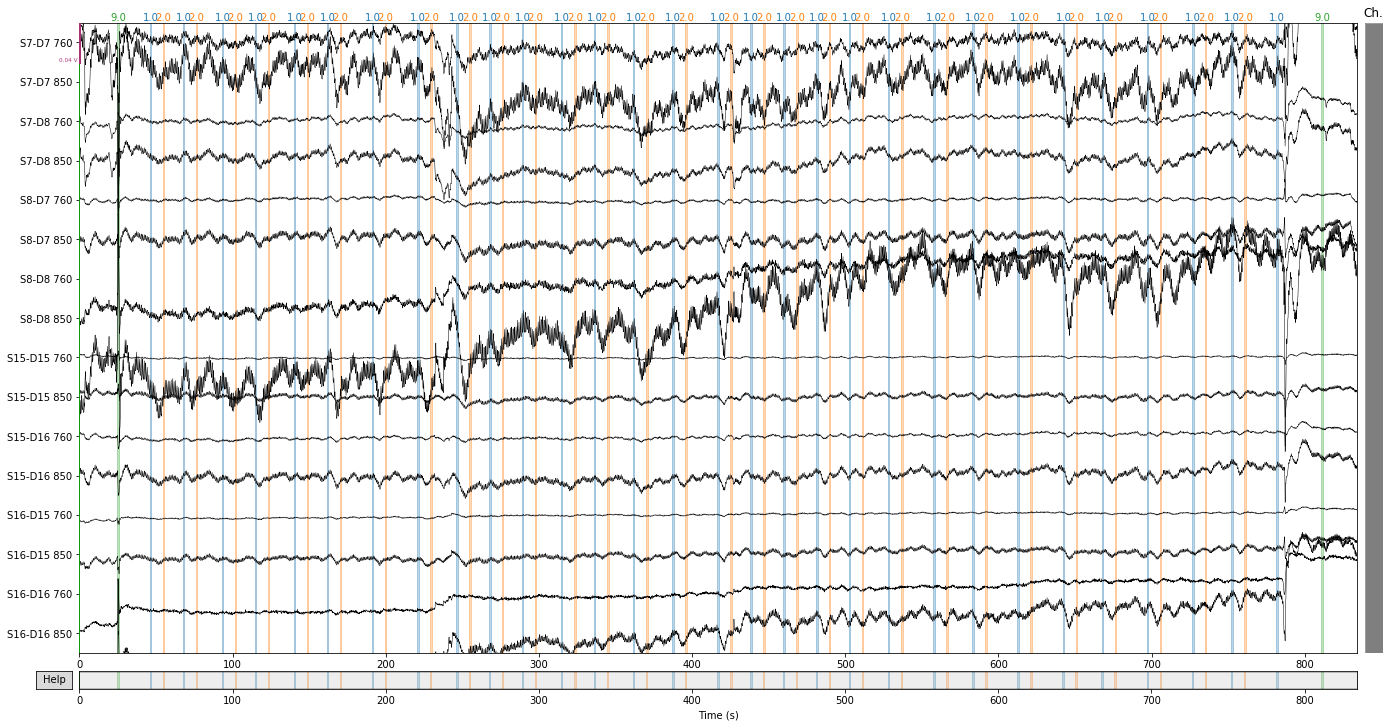

In [5]:
# %matplotlib qt
raw.plot(duration=900, start=0);

Effective window size : 262.144 (s)


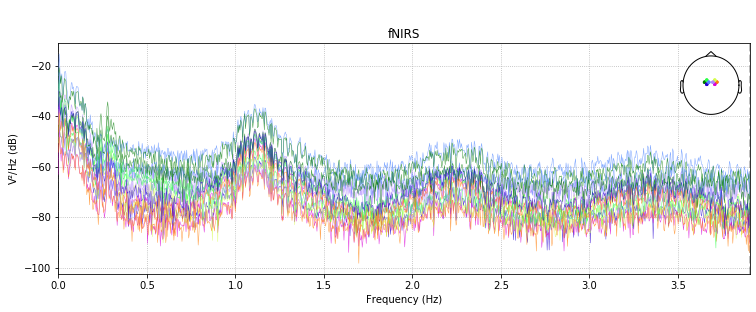

In [6]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,4)

raw.plot_psd();

In [7]:
raw = mne.preprocessing.optical_density(raw)
raw = mne.preprocessing.beer_lambert_law(raw)

In [8]:
raw = raw.filter(None, 0.7, h_trans_bandwidth = 0.2)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 129 samples (16.512 sec)



In [9]:
# Doesn't work yet for hbo/hbr
# raw.plot_psd();

## Extract epochs and plot average event

In [10]:
events, _ = mne.events_from_annotations(raw, event_id={'1.0': 1, '2.0': 2})
event_dict = {'Tapping': 1, 'Offset': 2}

Used Annotations descriptions: ['1.0', '2.0']


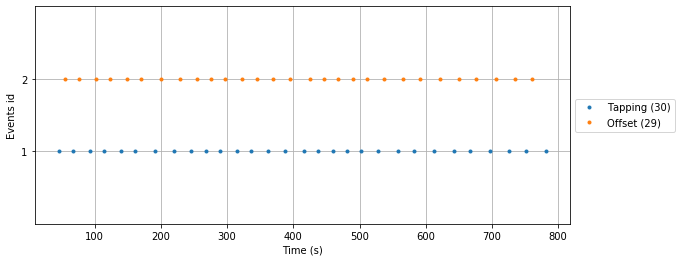

In [11]:
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'])
fig.subplots_adjust(right=0.7)  # make room for the legend

In [12]:
reject_criteria = dict(hbo=90e-6) 
event_dict = {'Tapping': 1, 'Offset': 2}
tmin, tmax = -8, 25

In [13]:
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=tmin, tmax=tmax,
                    reject=reject_criteria, reject_by_annotation=True,
                    proj=True, baseline=(-8, 0), preload=True, detrend = 1, verbose=True);

59 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 59 events and 258 original time points ...
    Rejecting  epoch based on HBO : ['S7-D7 hbo']
    Rejecting  epoch based on HBO : ['S7-D7 hbo', 'S7-D8 hbo']
    Rejecting  epoch based on HBO : ['S7-D7 hbo', 'S7-D8 hbo', 'S8-D8 hbo', 'S15-D15 hbo', 'S16-D15 hbo']
    Rejecting  epoch based on HBO : ['S7-D7 hbo', 'S7-D8 hbo', 'S8-D7 hbo', 'S8-D8 hbo', 'S15-D15 hbo']
    Rejecting  epoch based on HBO : ['S7-D7 hbo', 'S15-D15 hbo']
    Rejecting  epoch based on HBO : ['S7-D7 hbo', 'S7-D8 hbo', 'S8-D7 hbo', 'S8-D8 hbo', 'S15-D15 hbo', 'S15-D16 hbo', 'S16-D15 hbo', 'S16-D16 hbo']
6 bad epochs dropped


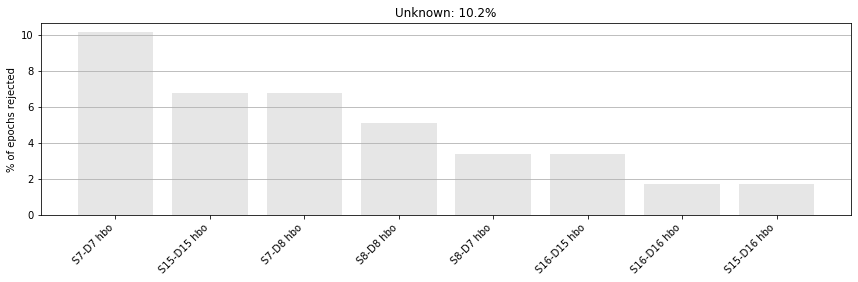

In [14]:
epochs.plot_drop_log();

In [15]:
# ROIs = dict(Left_ROI=['S3-D4 hbo'],
#            Right_ROI=['S8-D13 hbo'])

In [16]:
# plt.rcParams["figure.figsize"] = (4,4)
# epochs['Audio'].plot_sensors()

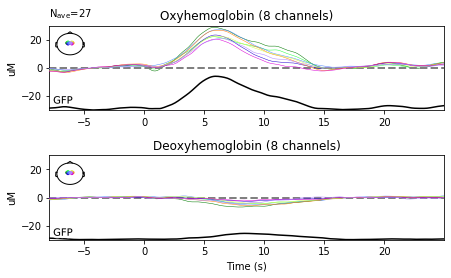

In [17]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,12)

epochs['Tapping'].average().plot(gfp = True, spatial_colors = True,
                                 ylim = dict(hbo=[-30, 30], hbr=[-30, 30]), 
                                 hline = [0.0]);


27 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


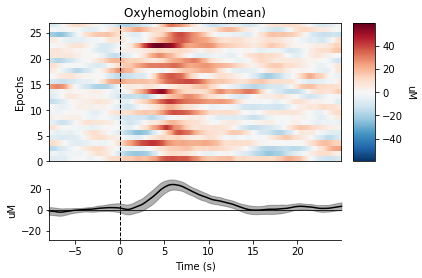

27 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


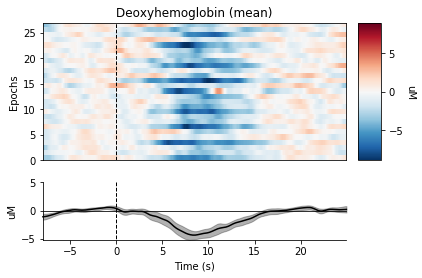

[<Figure size 432x288 with 3 Axes>]

In [18]:
%matplotlib inline

epochs['Tapping'].plot_image(combine = 'mean', picks = 'hbo')
epochs['Tapping'].plot_image(combine = 'mean', picks = 'hbr')

## Expected result

Below is an example from a random google search that shows the expected relation between hbo and hbr, which matches the above well (the length of response is different, this is stimulus dependent).

![https://d3i71xaburhd42.cloudfront.net/b2d157edfc1b161e51e51c4c373b11c0798ca8c4/2-Figure1-1.png](https://d3i71xaburhd42.cloudfront.net/b2d157edfc1b161e51e51c4c373b11c0798ca8c4/2-Figure1-1.png)